# Imports

In [2]:
import os
from dataPreprocessing import *
import pandas as pd
from torch.utils.data.dataset import random_split
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 64

torch.manual_seed(RANDOM_SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else('mps' if torch.backends.mps.is_available() else 'cpu'))
print(device)

cuda


In [4]:
def save_checkpoint(model, model_name, loss_fn='ce'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    os.makedirs(os.path.join(os.getcwd(), 'model_weights'), exist_ok=True)
    checkpoint = { # create a dictionary with all the state information
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, model_name, loss_fn='ce', map_location='cpu'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure correct device
    model.load_state_dict(checkpoint['model_state_dict'])

In [5]:
def plot_loss(train_loss_over_time, val_loss_over_time, model_name):
    epochs = range(1, len(train_loss_over_time) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_over_time, color='red', label='Train Loss')
    plt.plot(epochs, val_loss_over_time, color='blue', label='Val Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Loading Data

In [6]:
#folder path were dataset is located
path = 'dataset/'
#initialize empty lists to hold data
train_pos, train_neg, test_pos, test_neg = [], [], [], []
#create a dictionary where the key is the relative path to data and value is empty list
sets_dict = {'train/pos/': train_pos, 'train/neg/': train_neg, 'test/pos/': test_pos, 'test/neg/': test_neg}
#loop through dictionary to read from files and populate empty lists
for dataset in sets_dict:
        file_list = [file for file in os.listdir(os.path.join(path, dataset)) if file.endswith('.txt')]
        file_list = sorted(file_list)
        load_data(os.path.join(path, dataset), file_list, sets_dict[dataset])
#Covert lists to pandas dataframes and combine to form train and test datasets
train_data = pd.concat([pd.DataFrame({'review': train_pos, 'label':1}), pd.DataFrame({'review': train_neg, 'label':0})], axis = 0, ignore_index=True)
test_data = pd.concat([pd.DataFrame({'review': test_pos, 'label':1}), pd.DataFrame({'review': test_neg, 'label':0})], axis = 0, ignore_index=True)

In [7]:
#Visualize train_data dataframe
print(train_data.shape)
print(train_data.head())
print(train_data.tail())

(25000, 2)
                                              review  label
0  Bromwell High is a cartoon comedy. It ran at t...      1
1  Homelessness (or Houselessness as George Carli...      1
2  Brilliant over-acting by Lesley Ann Warren. Be...      1
3  This is easily the most underrated film inn th...      1
4  This is not the typical Mel Brooks film. It wa...      1
                                                  review  label
24995  Towards the end of the movie, I felt it was to...      0
24996  This is the kind of movie that my enemies cont...      0
24997  I saw 'Descent' last night at the Stockholm Fi...      0
24998  Some films that you pick up for a pound turn o...      0
24999  This is one of the dumbest films, I've ever se...      0


In [8]:
#Visualize test_data dataframe
print(test_data.shape)
print(test_data.head())
print(test_data.tail())

(25000, 2)
                                              review  label
0  I went and saw this movie last night after bei...      1
1  Actor turned director Bill Paxton follows up h...      1
2  As a recreational golfer with some knowledge o...      1
3  I saw this film in a sneak preview, and it is ...      1
4  Bill Paxton has taken the true story of the 19...      1
                                                  review  label
24995  I occasionally let my kids watch this garbage ...      0
24996  When all we have anymore is pretty much realit...      0
24997  The basic genre is a thriller intercut with an...      0
24998  Four things intrigued me as to this film - fir...      0
24999  David Bryce's comments nearby are exceptionall...      0


In [9]:
train_data["tokenized"] = train_data["review"].apply(lambda x: tokenize(clean_text(x.lower())))
test_data["tokenized"] = test_data["review"].apply(lambda x: tokenize(clean_text(x.lower())))

In [10]:
#Examine tokenized reviews
print(train_data.head()["tokenized"])

0    [bromwell, high, is, a, cartoon, comedy, ., it...
1    [homelessness, (, or, houselessness, as, georg...
2    [brilliant, over, -, acting, by, lesley, ann, ...
3    [this, is, easily, the, most, underrated, film...
4    [this, is, not, the, typical, mel, brooks, fil...
Name: tokenized, dtype: object


In [11]:
max = 0
total = 0
above_thresh = 0
for review in train_data["tokenized"]:
  if len(review) > max:
    max = len(review)
  total += len(review)
  if len(review) > 400:
    above_thresh += 1
print(max)
print(total/25000)
print(above_thresh)

2772
273.77724
4537


In [12]:
train_vocab, reversed_train_vocab = generate_vocab_map(train_data)

In [13]:
generator1 = torch.Generator().manual_seed(RANDOM_SEED)

train_dataset = ReviewDataset(train_vocab, train_data)
train_dataset, val_dataset = random_split(train_dataset,[0.9,0.1], generator=generator1)
test_dataset  = ReviewDataset(train_vocab, test_data)

train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)
test_sampler  = RandomSampler(test_dataset)

In [14]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [15]:
class SimpleSentimentTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dropout=0.1):
        super(SimpleSentimentTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Embedding(400, embed_dim) # max sequence length = 400
        encoder_layers = TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=embed_dim, dropout=dropout)
        # self.encoder_norm = nn.LayerNorm(embed_dim)
        # self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers, norm=self.encoder_norm)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(embed_dim, 2) # num_classes = 2
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        seq_length = x.size(1)
        pos = torch.arange(0, seq_length).unsqueeze(0).repeat(x.size(0), 1).to(x.device)
        x = self.embedding(x) + self.pos_encoder(pos)
        x = x.permute(1, 0, 2)  # change to (seq_len, batch_size, embed_dim)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # average pooling over sequence length
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [16]:
def get_accuracy_and_f1_score(y_true, y_predicted):
    """
    This function takes in two numpy arrays and computes the accuracy and F1 score
    between them. You can use the imported sklearn functions to do this.

    Args:
        y_true (list) : A 1D numpy array of ground truth labels
        y_predicted (list) : A 1D numpy array of predicted labels

    Returns:
        accuracy (float) : The accuracy of the predictions
        f1_score (float) : The F1 score of the predictions
    """

    accuracy = accuracy_score(y_true, y_predicted)

    f1 = f1_score(y_true, y_predicted, average='macro')

    return accuracy, f1

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

In [18]:
def sparsity_penalty_kl(encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1 - epsilon)
        kl_divergence = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
        sparsity_penalty = torch.sum(kl_divergence)
        return self.sparsity_lambda * sparsity_penalty

def sparsity_penalty_l1(encoded):
        return torch.sum(encoded, dim=1).mean()

def sparse_reconstruction_loss(x_hat, x, encoded):
        sparsity_penalty = sparsity_penalty_l1(encoded)
        mse_loss = F.mse_loss(x_hat, x, reduction='mean')
        return sparsity_penalty + mse_loss


In [19]:
def get_criterion(loss_type='ce'):
    criterion = None

    ## YOUR CODE STARTS HERE ##
    if loss_type == 'ce':
        criterion = nn.CrossEntropyLoss()
    elif loss_type == 'sr':
        criterion = sparse_reconstruction_loss
    elif loss_type == 'mse':
        criterion = nn.MSELoss()

    ## YOUR CODE ENDS HERE ##

    return criterion

In [20]:
def get_optimizer(model, learning_rate):
    """
    This function takes a model and a learning rate, and returns an optimizer.
    Feel free to experiment with different optimizers.
    """
    optimizer = None

    ## YOUR CODE STARTS HERE ##
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ## YOUR CODE ENDS HERE ##

    return optimizer

In [21]:
def train_loop(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    for x, y in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###
        # remove this when you add your implementation
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)

        # output = output.long()
        y = y.long()

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

In [22]:
def val_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
         # remove this when you add your implementation
         x, y = x.to(device), y.to(device)
         output = model(x)

        #  output = output.long()
         y = y.long()

         loss = criterion(output, y)

         total_loss += loss.item()
         true.extend(y.tolist())
         predicted = torch.argmax(output, dim=1)
         pred.extend(predicted.tolist())


    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [23]:
def test_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the test set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
         # remove this when you add your implementation
         x, y = x.to(device), y.to(device)
         output = model(x)

        #  output = output.long()
         y = y.long()

         loss = criterion(output, y)

         total_loss += loss.item()
         true.extend(y.tolist())
         predicted = torch.argmax(output, dim=1)
         pred.extend(predicted.tolist())


    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [24]:
def get_hyperparams_transformer():
    VOCAB_SIZE = len(train_vocab)
    EMBED_DIM = 4
    NUM_HEADS = 1
    NUM_LAYERS = 1
    DROPOUT = 0.1
    LEARNING_RATE = 0.015
    EPOCHS = 2
    return VOCAB_SIZE, EMBED_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT, LEARNING_RATE, EPOCHS

In [25]:
def get_transformer_model(vocab_size, embedding_dim, num_heads, num_layers, dropout):
    model = SimpleSentimentTransformer(
        vocab_size=vocab_size,
        embed_dim=embedding_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout=dropout
    )
    return model

In [26]:
VOCAB_SIZE, EMBED_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT, LEARNING_RATE, EPOCHS = get_hyperparams_transformer()

transformer_model = get_transformer_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)
load_checkpoint(transformer_model, 'transformer2', map_location=device)
criterion = get_criterion()

# evaluate model
true, pred, val_loss = test_loop(transformer_model, criterion, test_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Test Accuracy: {accuracy}")
print(f"Final Test F1-Score: {f1}")

c:\Users\aadar\miniconda3\envs\cs7650-hw\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\aadar\AppData\Local\Temp\ipykernel_19280\1142292354.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lo

Final Test Accuracy: 0.87276
Final Test F1-Score: 0.8726350623323684


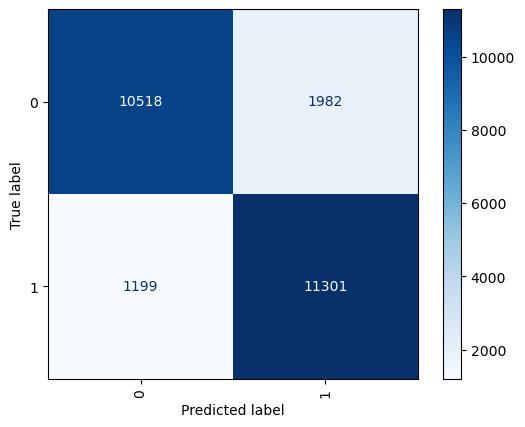

In [27]:
plot_confusion_matrix(true, pred, classes=[0, 1])

In [28]:
activation = {'fc': torch.empty((0, 4), device=device)}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = torch.cat([activation[name], torch.flatten(output.detach(), start_dim=0, end_dim=1)]) 
    return hook

handle = transformer_model.transformer_encoder.register_forward_hook(get_activation('fc'))

In [5]:

arr = torch.rand(2,3,5)
print(arr)
print(torch.flatten(arr,start_dim=0, end_dim=1))
arr = torch.flatten(arr,start_dim=0, end_dim=1)
print(arr.reshape(2,3,5))

tensor([[[0.6415, 0.9876, 0.2350, 0.2678, 0.3886],
         [0.5328, 0.4887, 0.6187, 0.6111, 0.1479],
         [0.7043, 0.0854, 0.0809, 0.7662, 0.6667]],

        [[0.8218, 0.5159, 0.5697, 0.6841, 0.5637],
         [0.6115, 0.8802, 0.8642, 0.0290, 0.3633],
         [0.2903, 0.9298, 0.8392, 0.6306, 0.0910]]])
tensor([[0.6415, 0.9876, 0.2350, 0.2678, 0.3886],
        [0.5328, 0.4887, 0.6187, 0.6111, 0.1479],
        [0.7043, 0.0854, 0.0809, 0.7662, 0.6667],
        [0.8218, 0.5159, 0.5697, 0.6841, 0.5637],
        [0.6115, 0.8802, 0.8642, 0.0290, 0.3633],
        [0.2903, 0.9298, 0.8392, 0.6306, 0.0910]])
tensor([[[0.6415, 0.9876, 0.2350, 0.2678, 0.3886],
         [0.5328, 0.4887, 0.6187, 0.6111, 0.1479],
         [0.7043, 0.0854, 0.0809, 0.7662, 0.6667]],

        [[0.8218, 0.5159, 0.5697, 0.6841, 0.5637],
         [0.6115, 0.8802, 0.8642, 0.0290, 0.3633],
         [0.2903, 0.9298, 0.8392, 0.6306, 0.0910]]])


In [29]:
true, pred, train_loss = test_loop(transformer_model, criterion, train_iterator)
act_train = activation['fc'].clone()
print(act_train.shape)

activation = {'fc': torch.empty((0, 4), device=device)}
true, pred, val_loss = test_loop(transformer_model, criterion, val_iterator)
act_val = activation['fc'].clone()
print(act_val.shape)

activation = {'fc': torch.empty((0, 4), device=device)}
true, pred, test_loss = test_loop(transformer_model, criterion, test_iterator)
act_test = activation['fc'].clone()
print(act_test.shape)

Evaluating Model: 100%|██████████| 352/352 [01:27<00:00,  4.01it/s]


torch.Size([9000000, 4])


Evaluating Model: 100%|██████████| 40/40 [00:03<00:00, 12.15it/s]


torch.Size([1000000, 4])


Evaluating Model: 100%|██████████| 391/391 [00:11<00:00, 34.90it/s]

torch.Size([10000000, 4])


In [30]:
handle.remove()

In [31]:
class SAE(nn.Module):
    def __init__(self, latent_size=64):
        super(SAE, self).__init__()
        self.latent_size = latent_size
        self.W = nn.Parameter(torch.rand(4, latent_size)) # tied weights for training!
        self.b = nn.Parameter(torch.rand(latent_size))
        
    def forward(self, x):
        encoded = F.relu(torch.mm(x, self.W) + self.b)
        decoded = torch.mm(encoded, torch.transpose(self.W, 0, 1))
        return encoded, decoded

In [32]:
class KSAE(nn.Module):
    def __init__(self, latent_size=64, top_k=16):
        super(KSAE, self).__init__()
        self.latent_size = latent_size
        self.top_k = top_k
        self.W = nn.Parameter(torch.rand(4, latent_size)) # tied weights for training!
        self.b = nn.Parameter(torch.rand(latent_size))
        
    def forward(self, x):
        encoded_acts = F.relu(torch.mm(x, self.W) + self.b)
        encoded_topk = torch.topk(encoded_acts, self.top_k, dim=-1)
        encoded_topk = torch.zeros_like(encoded_acts).scatter(
            -1, encoded_topk.indices, encoded_topk.values
        )
        decoded = torch.mm(encoded_topk, torch.transpose(self.W, 0, 1))
        return decoded

    def get_encoded(self, x):
        encoded_acts = F.relu(torch.mm(x, self.W) + self.b)
        encoded_topk = torch.topk(encoded_acts, self.top_k, dim=-1)
        encoded_topk = torch.zeros_like(encoded_acts).scatter(
            -1, encoded_topk.indices, encoded_topk.values
        )
        return encoded_topk

In [33]:
def train_loop_sae(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    for x in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###
        # remove this when you add your implementation
        
        x = x[0].to(device)
        optimizer.zero_grad()
        encoded, decoded = model(x)

        # print(encoded.shape())
        # print(decoded.shape())

        loss = criterion(decoded, x, encoded)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

In [34]:
def val_loop_sae(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
         # remove this when you add your implementation
         x = x[0].to(device)
         encoded, decoded = model(x)

         loss = criterion(decoded, x, encoded)

         total_loss += loss.item()
         true.extend(x.tolist())
         predicted = decoded
         pred.extend(predicted.tolist())


    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [35]:
def test_loop_sae(model, criterion, iterator):
    """
    This function is used to evaluate a model on the test set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
         # remove this when you add your implementation
         x = x[0].to(device) 
         encoded, decoded = model(x)

         loss = criterion(decoded, x, encoded)

         total_loss += loss.item()
         true.extend(x.tolist())
         predicted = decoded
         pred.extend(predicted.tolist())


    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [36]:
def train_loop_ksae(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    for x in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###
        # remove this when you add your implementation
        x = x[0].to(device)
        optimizer.zero_grad()
        x_hat = model(x)

        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

In [37]:
def val_loop_ksae(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
         # remove this when you add your implementation
         x = x[0].to(device)
         x_hat = model(x)

         loss = criterion(x_hat, x)

         total_loss += loss.item()
         true.extend(x.tolist())
         predicted = x_hat
         pred.extend(predicted.tolist())

    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [38]:
def test_loop_ksae(model, criterion, iterator):
    """
    This function is used to evaluate a model on the test set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
         # remove this when you add your implementation
         x = x[0].to(device) 
         x_hat = model(x)

         loss = criterion(x_hat, x)

         total_loss += loss.item()
         true.extend(x.tolist())
         predicted = x_hat
         pred.extend(predicted.tolist())


    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [39]:
def ksae_get_encoded(model, iterator):
    """
    This function is used to evaluate a model on the test set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    pred = []
    pred_stacked = []
    model.eval()
    for x in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
         x = x[0].to(device) 
         x_encoded = model.get_encoded(x)
         pred.extend(x_encoded)
    pred = torch.stack(pred, dim=0)
    return pred

In [40]:
sae_train_dataset = torch.utils.data.TensorDataset(act_train)
sae_val_dataset = torch.utils.data.TensorDataset(act_val)
sae_test_dataset = torch.utils.data.TensorDataset(act_test)

sae_train_sampler = RandomSampler(sae_train_dataset)
sae_val_sampler = RandomSampler(sae_val_dataset)
sae_test_sampler  = RandomSampler(sae_test_dataset)

sae_train_iterator = DataLoader(sae_train_dataset, batch_size=BATCH_SIZE, sampler=sae_train_sampler)
sae_val_iterator = DataLoader(sae_val_dataset, batch_size=BATCH_SIZE, sampler=sae_val_sampler)
sae_test_iterator = DataLoader(sae_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# sae_test_iterator  = DataLoader(sae_test_dataset, batch_size=BATCH_SIZE, sampler=sae_test_sampler)

In [41]:
def get_hyperparams_sae():
    LATENT_SIZE = 64
    LEARNING_RATE = 0.001
    EPOCHS = 20
    return LATENT_SIZE, LEARNING_RATE, EPOCHS

In [42]:
def get_sae_model(latent_size):
    model = SAE(
        latent_size=latent_size
    )
    return model

In [60]:
LATENT_SIZE, LEARNING_RATE, EPOCHS = get_hyperparams_sae()

sae_model = get_sae_model(
    latent_size=LATENT_SIZE
).to(device)

criterion = get_criterion(loss_type='sr')
optimizer = get_optimizer(sae_model, LEARNING_RATE)
train_loss_over_time_sae = []
val_loss_over_time_sae = []

for epoch in range(EPOCHS):
    train_loss = train_loop_sae(sae_model, criterion, optimizer, sae_train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop_sae(sae_model, criterion, sae_val_iterator) # change to val
    # accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss}")
    train_loss_over_time_sae.append(train_loss)
    val_loss_over_time_sae.append(val_loss)
save_checkpoint(sae_model, 'sae')

Training Model:  17%|█▋        | 23320/140625 [00:31<02:37, 743.24it/s]


KeyboardInterrupt: 

In [43]:
def get_hyperparams_ksae():
    LATENT_SIZE = 64
    TOP_K = 8
    LEARNING_RATE = 0.005
    EPOCHS = 4
    return LATENT_SIZE, TOP_K, LEARNING_RATE, EPOCHS

In [44]:
def get_ksae_model(latent_size, top_k):
    model = KSAE(
        latent_size=latent_size, 
        top_k=top_k
    )
    return model

In [47]:
LATENT_SIZE, TOP_K, LEARNING_RATE, EPOCHS = get_hyperparams_ksae()

ksae_model = get_ksae_model(
    latent_size=LATENT_SIZE, 
    top_k=TOP_K
).to(device)

criterion = get_criterion(loss_type='mse')
optimizer = get_optimizer(ksae_model, LEARNING_RATE)
train_loss_over_time_ksae = []
val_loss_over_time_ksae = []

for epoch in range(EPOCHS):
    train_loss = train_loop_ksae(ksae_model, criterion, optimizer, sae_train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop_ksae(ksae_model, criterion, sae_val_iterator) # change to val
    # accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss}")
    train_loss_over_time_ksae.append(train_loss)
    val_loss_over_time_ksae.append(val_loss)
save_checkpoint(ksae_model, 'ksae')

Evaluating Model: 100%|██████████| 15625/15625 [00:19<00:00, 794.50it/s] 


Epoch 1 -- Train_Loss: 0.017314446519556367 -- Val_Loss: 3.834713530450244e-06


Evaluating Model: 100%|██████████| 15625/15625 [00:16<00:00, 948.81it/s] 


Epoch 2 -- Train_Loss: 5.520670896890636e-06 -- Val_Loss: 4.847118250222593e-08


Evaluating Model: 100%|██████████| 15625/15625 [00:17<00:00, 906.22it/s] 


Epoch 3 -- Train_Loss: 4.864684161816269e-06 -- Val_Loss: 6.665943998609692e-08


Evaluating Model: 100%|██████████| 15625/15625 [00:17<00:00, 869.97it/s] 


Epoch 4 -- Train_Loss: 4.389941944773593e-06 -- Val_Loss: 4.0227088294705026e-07
Checkpoint saved to c:\Users\aadar\Documents\Sentiment-Analysis-Intepreter\model_weights\checkpoint_ksae_ce.pt


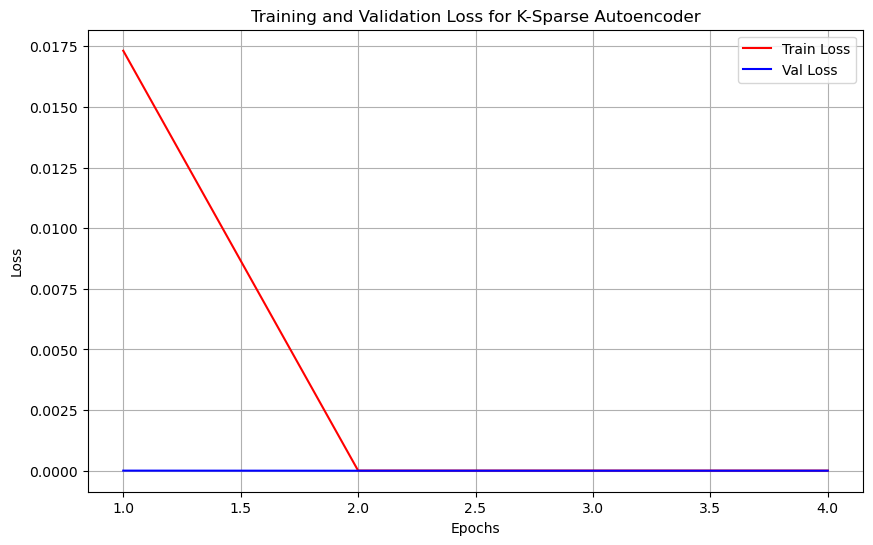

In [48]:
plot_loss(train_loss_over_time_ksae, val_loss_over_time_ksae, 'K-Sparse Autoencoder')

In [47]:
LATENT_SIZE, TOP_K, LEARNING_RATE, EPOCHS = get_hyperparams_ksae()

ksae_model = get_ksae_model(
    latent_size=LATENT_SIZE, 
    top_k=TOP_K
).to(device)

load_checkpoint(ksae_model, 'ksae', map_location=device)
criterion = get_criterion(loss_type='mse')

# evaluate model
# true, pred, val_loss = test_loop_ksae(ksae_model, criterion, test_iterator)


C:\Users\aadar\AppData\Local\Temp\ipykernel_19280\1142292354.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_locatio

In [48]:
test_data = next(iter(sae_test_iterator))
print(test_data[0][0])

test_pred = ksae_model(test_data[0])
print(torch.norm(test_data[0] - test_pred))

encoded_acts = F.relu(torch.mm(test_data[0], ksae_model.W) + ksae_model.b)
encoded_topk = torch.topk(encoded_acts, ksae_model.top_k, dim=-1)
encoded_topk = torch.zeros_like(encoded_acts).scatter(-1, encoded_topk.indices, encoded_topk.values)

print(encoded_topk[2])


tensor([-0.5920, -2.8094,  2.1098,  0.4306], device='cuda:0')
tensor(0.0099, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0739, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.2244, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.5468, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.5507, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0', grad_fn=<SelectBackward0>)


In [49]:
latent_activations = ksae_get_encoded(ksae_model, sae_test_iterator)
print(latent_activations.shape)

Evaluating Model: 100%|██████████| 156250/156250 [03:02<00:00, 856.95it/s] 


torch.Size([10000000, 64])


In [51]:
act_a, act_b = torch.tensor_split(latent_activations, 2, dim=0)

In [55]:
act_a = act_a.to(torch.device("cpu"))
act_b = act_b.to(torch.device("cpu"))

In [56]:
act_a = act_a.clone()
torch.save(act_a, "model_weights/ksae_latent_activations_a.pt")

In [57]:
act_b = act_b.clone()
torch.save(act_b, "model_weights/ksae_latent_activations_b.pt")

In [54]:
print(act_a.shape)

torch.Size([5000000, 64])


In [52]:
torch.save(act_a, "model_weights/ksae_latent_activations_a.pt")

In [53]:
torch.save(act_b, "model_weights/ksae_latent_activations_b.pt")